In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import time
import pandas as pd
import numpy as np
# import seaborn as sns
import tensorflow as tf
import gc
# import cv2
from tqdm import tqdm
# from tensorflow import keras
# from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
# from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# from matplotlib import pyplot as plt


notebook_dir = os.getcwd()
target_path = os.path.abspath(os.path.join(notebook_dir, '../Python_Code'))
sys.path.append(target_path)
from dataGenerator import DataGenerator

import util

2025-05-17 11:37:13.551822: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-17 11:37:13.660207: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-17 11:37:13.675950: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-17 11:37:13.849619: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-17 11:37:14.896989: W tensorflow/compiler/tf2

In [2]:
csvs = pd.read_csv('../EDA/SAIDAS/04-csv_summary.csv', usecols=['test', 'environment', 'monitor', 'slot', 'csv_file_path'])
csvs.drop_duplicates(inplace=True)
csvs = csvs.loc[(csvs['test']=='proximity')&(csvs['slot'].str.contains("Test"))]
csvs.reset_index(drop=True, inplace=True)

In [46]:
def processing(row):
  start_time = time.time()
  
  # Constants
  window_size = 50
  NoOfSubcarrier = 242
  labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']

  # File and directory paths
  environment, csv_file_path, monitor, slot = row[['environment', 'csv_file_path', 'monitor', 'slot']]
  target_subject = slot.replace('Test_', '')
  test_dir = os.path.dirname(csv_file_path)
  model_dir = os.path.dirname(os.path.dirname(os.path.dirname(csv_file_path)))
  gradcam_dir = test_dir.replace('Data', 'GradCam')
  model_path = f'{model_dir}/{environment}_{monitor}_{target_subject}.h5'
  csv_output_file = csv_file_path.replace('Data', 'GradCam')

  # File and directory checks
  if not os.path.exists(csv_file_path):
    print(f'Test directory not found: {csv_file_path}')
    return None
  if not os.path.exists(model_path):
    print(f'Model path not found: {model_path}')
    return None
  if not os.path.exists(csv_file_path):
    print(f'CSV file path not found: {csv_file_path}')
    return None
  if not os.path.exists(gradcam_dir):
    os.makedirs(gradcam_dir)

  print(f'Processing {csv_file_path} with model {model_path}')

  # Load model
  model = load_model(model_path)

  # Load data
  csv = pd.read_csv(csv_file_path)
  csv['predicted_label'] = None
  csv['predicted_prob'] = None

  # Data generator
  test_gen = DataGenerator(test_dir, csv_file_path, NoOfSubcarrier, len(labels), (window_size, NoOfSubcarrier, 2), batchsize=1, shuffle=False)

  # Loop into test samples
  for sample_index in tqdm(range(len(test_gen))):
    x, y = test_gen[sample_index]
    mat_file = csv.iloc[sample_index]['filename']
    npy_file = f"{gradcam_dir}/{mat_file.replace('.mat', '.npy')}"
    png_file = npy_file.replace('.npy', '.png')

    # Check if the Grad-CAM file already exists
    if not os.path.exists(npy_file):
      gradcam_basefolder = os.path.dirname(npy_file)
      if not os.path.exists(gradcam_basefolder):
        os.makedirs(gradcam_basefolder)

      top_pred_index, top_class_channel = util.make_gradcam_heatmap(x, model, npy_file, png_file)
      csv.at[sample_index, 'predicted_label'] = labels[top_pred_index]
      csv.at[sample_index, 'predicted_prob'] = top_class_channel.numpy()[0]

  csv['right'] = csv['predicted_label'] == csv['label']
  csv.to_csv(csv_output_file, index=False)

  # Free GPU memory
  del model
  gc.collect()
  tf.keras.backend.clear_session()

  end_time = time.time()
  elapsed_time = end_time - start_time
  row['elapsed_time_seconds'] = elapsed_time

  return row  

csvs = csvs.apply(processing, axis=1)
csvs


Processing ../Data/proximity/Classroom/80MHz/3mo/m1/Slots/Test_m1/test_set.csv with model ../Data/proximity/Classroom/80MHz/3mo/m1/Classroom_m1_m1.h5


  0%|          | 0/19749 [00:00<?, ?it/s]/home/diogo/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 50, 242, 2))
  warnings.warn(msg)
100%|██████████| 19749/19749 [08:24<00:00, 39.12it/s]


Processing ../Data/proximity/Classroom/80MHz/3mo/m1/Slots/Test_m2/test_set.csv with model ../Data/proximity/Classroom/80MHz/3mo/m1/Classroom_m1_m2.h5


  0%|          | 0/19084 [00:00<?, ?it/s]/home/diogo/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 50, 242, 2))
  warnings.warn(msg)
100%|██████████| 19084/19084 [08:20<00:00, 38.12it/s]


Processing ../Data/proximity/Classroom/80MHz/3mo/m1/Slots/Test_m3/test_set.csv with model ../Data/proximity/Classroom/80MHz/3mo/m1/Classroom_m1_m3.h5


  0%|          | 0/19084 [00:00<?, ?it/s]/home/diogo/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 50, 242, 2))
  warnings.warn(msg)
100%|██████████| 19084/19084 [08:08<00:00, 39.04it/s]


Processing ../Data/proximity/Classroom/80MHz/3mo/m2/Slots/Test_m1/test_set.csv with model ../Data/proximity/Classroom/80MHz/3mo/m2/Classroom_m2_m1.h5


  0%|          | 0/19587 [00:00<?, ?it/s]/home/diogo/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 50, 242, 2))
  warnings.warn(msg)
100%|██████████| 19587/19587 [08:55<00:00, 36.57it/s]


Processing ../Data/proximity/Classroom/80MHz/3mo/m2/Slots/Test_m2/test_set.csv with model ../Data/proximity/Classroom/80MHz/3mo/m2/Classroom_m2_m2.h5


  0%|          | 0/18930 [00:00<?, ?it/s]/home/diogo/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 50, 242, 2))
  warnings.warn(msg)
100%|██████████| 18930/18930 [08:12<00:00, 38.43it/s]


Processing ../Data/proximity/Classroom/80MHz/3mo/m2/Slots/Test_m3/test_set.csv with model ../Data/proximity/Classroom/80MHz/3mo/m2/Classroom_m2_m3.h5


  0%|          | 0/18930 [00:00<?, ?it/s]/home/diogo/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 50, 242, 2))
  warnings.warn(msg)
100%|██████████| 18930/18930 [08:04<00:00, 39.05it/s]


Processing ../Data/proximity/Classroom/80MHz/3mo/m3/Slots/Test_m1/test_set.csv with model ../Data/proximity/Classroom/80MHz/3mo/m3/Classroom_m3_m1.h5


  0%|          | 0/20219 [00:00<?, ?it/s]/home/diogo/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 50, 242, 2))
  warnings.warn(msg)
100%|██████████| 20219/20219 [08:57<00:00, 37.60it/s]


Processing ../Data/proximity/Classroom/80MHz/3mo/m3/Slots/Test_m2/test_set.csv with model ../Data/proximity/Classroom/80MHz/3mo/m3/Classroom_m3_m2.h5


  0%|          | 0/19541 [00:00<?, ?it/s]/home/diogo/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 50, 242, 2))
  warnings.warn(msg)
100%|██████████| 19541/19541 [08:21<00:00, 38.97it/s]


Processing ../Data/proximity/Classroom/80MHz/3mo/m3/Slots/Test_m3/test_set.csv with model ../Data/proximity/Classroom/80MHz/3mo/m3/Classroom_m3_m3.h5


  0%|          | 0/19541 [00:00<?, ?it/s]/home/diogo/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 50, 242, 2))
  warnings.warn(msg)
100%|██████████| 19541/19541 [08:30<00:00, 38.30it/s]


Processing ../Data/proximity/Office/80MHz/3mo/m1/Slots/Test_m1/test_set.csv with model ../Data/proximity/Office/80MHz/3mo/m1/Office_m1_m1.h5


  0%|          | 0/30679 [00:00<?, ?it/s]/home/diogo/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 50, 242, 2))
  warnings.warn(msg)
100%|██████████| 30679/30679 [13:58<00:00, 36.57it/s]


Processing ../Data/proximity/Office/80MHz/3mo/m1/Slots/Test_m2/test_set.csv with model ../Data/proximity/Office/80MHz/3mo/m1/Office_m1_m2.h5


  0%|          | 0/29648 [00:00<?, ?it/s]/home/diogo/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 50, 242, 2))
  warnings.warn(msg)
100%|██████████| 29648/29648 [13:48<00:00, 35.77it/s]


Processing ../Data/proximity/Office/80MHz/3mo/m1/Slots/Test_m3/test_set.csv with model ../Data/proximity/Office/80MHz/3mo/m1/Office_m1_m3.h5


  0%|          | 0/29648 [00:00<?, ?it/s]/home/diogo/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 50, 242, 2))
  warnings.warn(msg)
100%|██████████| 29648/29648 [15:32<00:00, 31.78it/s]


Processing ../Data/proximity/Office/80MHz/3mo/m2/Slots/Test_m1/test_set.csv with model ../Data/proximity/Office/80MHz/3mo/m2/Office_m2_m1.h5


  0%|          | 0/32365 [00:00<?, ?it/s]/home/diogo/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 50, 242, 2))
  warnings.warn(msg)
100%|██████████| 32365/32365 [15:53<00:00, 33.95it/s]


Processing ../Data/proximity/Office/80MHz/3mo/m2/Slots/Test_m2/test_set.csv with model ../Data/proximity/Office/80MHz/3mo/m2/Office_m2_m2.h5


  0%|          | 0/31281 [00:00<?, ?it/s]/home/diogo/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 50, 242, 2))
  warnings.warn(msg)
100%|██████████| 31281/31281 [16:15<00:00, 32.06it/s]


Processing ../Data/proximity/Office/80MHz/3mo/m2/Slots/Test_m3/test_set.csv with model ../Data/proximity/Office/80MHz/3mo/m2/Office_m2_m3.h5


  0%|          | 0/31281 [00:00<?, ?it/s]/home/diogo/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 50, 242, 2))
  warnings.warn(msg)
100%|██████████| 31281/31281 [15:53<00:00, 32.79it/s]


Processing ../Data/proximity/Office/80MHz/3mo/m3/Slots/Test_m1/test_set.csv with model ../Data/proximity/Office/80MHz/3mo/m3/Office_m3_m1.h5


  0%|          | 0/30383 [00:00<?, ?it/s]/home/diogo/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 50, 242, 2))
  warnings.warn(msg)
100%|██████████| 30383/30383 [16:26<00:00, 30.79it/s]


Processing ../Data/proximity/Office/80MHz/3mo/m3/Slots/Test_m2/test_set.csv with model ../Data/proximity/Office/80MHz/3mo/m3/Office_m3_m2.h5


  0%|          | 0/29360 [00:00<?, ?it/s]/home/diogo/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 50, 242, 2))
  warnings.warn(msg)
100%|██████████| 29360/29360 [15:52<00:00, 30.84it/s]


Processing ../Data/proximity/Office/80MHz/3mo/m3/Slots/Test_m3/test_set.csv with model ../Data/proximity/Office/80MHz/3mo/m3/Office_m3_m3.h5


  0%|          | 0/29360 [00:00<?, ?it/s]/home/diogo/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 50, 242, 2))
  warnings.warn(msg)
100%|██████████| 29360/29360 [15:57<00:00, 30.66it/s]


,test,environment,monitor,slot,csv_file_path,elapsed_time_seconds
0,proximity,Classroom,m1,Test_m1,../Data/proximity/Classroom/80MHz/3mo/m1/Slots...,507.651038
1,proximity,Classroom,m1,Test_m2,../Data/proximity/Classroom/80MHz/3mo/m1/Slots...,503.202627
2,proximity,Classroom,m1,Test_m3,../Data/proximity/Classroom/80MHz/3mo/m1/Slots...,491.408673
3,proximity,Classroom,m2,Test_m1,../Data/proximity/Classroom/80MHz/3mo/m2/Slots...,538.526809
4,proximity,Classroom,m2,Test_m2,../Data/proximity/Classroom/80MHz/3mo/m2/Slots...,495.169215
5,proximity,Classroom,m2,Test_m3,../Data/proximity/Classroom/80MHz/3mo/m2/Slots...,487.401974
6,proximity,Classroom,m3,Test_m1,../Data/proximity/Classroom/80MHz/3mo/m3/Slots...,540.595021
7,proximity,Classroom,m3,Test_m2,../Data/proximity/Classroom/80MHz/3mo/m3/Slots...,504.182124
8,proximity,Classroom,m3,Test_m3,../Data/proximity/Classroom/80MHz/3mo/m3/Slots...,512.920758
9,proximity,Office,m1,Test_m1,../Data/proximity/Office/80MHz/3mo/m1/Slots/Te...,843.003301


In [48]:
csvs.to_csv('SAIDAS/03-csv_summary_gradcam_proximity.csv', index=False)

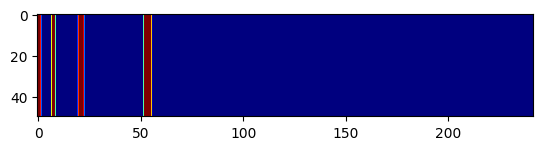

In [148]:
gradcam_line = gradcam.sum(axis=0)/50

# concat gradcam_line (242,1) to a (242,50)
gradcam_line = gradcam_line.reshape(1, 242)

# concactenate the gradcam_line 50 times
gradcam_all = np.repeat(gradcam_line, 50, axis=0)

# gradcam_all = sigmoid(gradcam_all, 0.00001)
# show the gradcam_line

gradcam_all = np.where(gradcam_all >= 0.40, 1, 0)
plt.imshow(gradcam_all, cmap='jet');
# plt.imshow(gradcam.sum(axis=0),  cmap='jet')

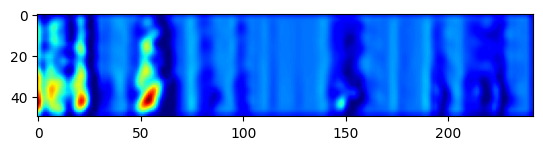

In [ ]:
plt.imshow(gradcam, cmap='jet')

In [108]:
gradcam_line

array([[0.50338906, 0.440587  , 0.31498292, 0.26719236, 0.2972154 ,
        0.33971503, 0.39469147, 0.4158467 , 0.4031807 , 0.38043237,
        0.34760198, 0.31261382, 0.27546805, 0.2253223 , 0.16217667,
        0.12937476, 0.12691647, 0.17261894, 0.26648217, 0.35710078,
        0.44447467, 0.46281037, 0.41210783, 0.31178054, 0.16182846,
        0.06536837, 0.02240021, 0.01789177, 0.05184306, 0.09331001,
        0.14229259, 0.16819187, 0.17100805, 0.17495371, 0.18002892,
        0.19265148, 0.21282148, 0.23019142, 0.24476133, 0.25507304,
        0.2611265 , 0.25921613, 0.24934192, 0.22988133, 0.20083429,
        0.18218312, 0.17392784, 0.1825391 , 0.2080171 , 0.25660604,
        0.32830605, 0.3886815 , 0.43773267, 0.45845413, 0.450846  ,
        0.42020664, 0.36653632, 0.3038618 , 0.232183  , 0.16378547,
        0.09866916, 0.05308773, 0.02704117, 0.0175116 , 0.02449901,
        0.04244739, 0.07135677, 0.10359867, 0.13917312, 0.16758727,
        0.18884113, 0.21137899, 0.23520094, 0.25

In [118]:
sigmoid(gradcam_line, 0.1)

array([[0.5125821 , 0.5110129 , 0.50787395, 0.5066794 , 0.50742984,
        0.50849205, 0.509866  , 0.5103947 , 0.5100782 , 0.5095097 ,
        0.50868917, 0.5078147 , 0.5068863 , 0.5056328 , 0.5040543 ,
        0.5032343 , 0.5031729 , 0.5043154 , 0.50666165, 0.5089266 ,
        0.51111007, 0.5115682 , 0.51030123, 0.50779384, 0.5040456 ,
        0.5016342 , 0.50056005, 0.5004473 , 0.50129604, 0.50233275,
        0.50355726, 0.5042047 , 0.5042751 , 0.5043737 , 0.5045006 ,
        0.5048162 , 0.5053203 , 0.50575453, 0.5061187 , 0.5063765 ,
        0.5065278 , 0.50648004, 0.5062332 , 0.5057468 , 0.5050207 ,
        0.50455445, 0.5043481 , 0.50456333, 0.50520027, 0.5064148 ,
        0.50820696, 0.5097158 , 0.51094157, 0.51145935, 0.5112692 ,
        0.51050365, 0.50916237, 0.50759596, 0.5058043 , 0.50409454,
        0.50246674, 0.5013272 , 0.50067604, 0.5004378 , 0.5006125 ,
        0.5010612 , 0.50178385, 0.50258994, 0.50347924, 0.50418955,
        0.50472087, 0.50528425, 0.50587976, 0.50

In [ ]:
  prediction_confidence_file = csv_output_file.replace('test_set.csv', 'prediction_confidence.png')

csv['right'] = csv['predicted_label'] == csv['label']
right = csv.loc[csv['right'] == True, 'predicted_prob'].tolist()
wrong = csv.loc[csv['right'] == False, 'predicted_prob'].tolist()
title = f"{model_path.split('/')[2]}_{model_path.split('/')[-1]}"
plot_continuous_distribution(right, wrong, title=title, output=prediction_confidence_file)

In [ ]:
rows = len(gradcam)
cols = 1

fig, axs = plt.subplots(rows, cols, figsize=(14, 4*rows))
for i in range(rows):
    axs[i].imshow(gradcam[i], cmap='jet')
    axs[i].set_title(labels[i])
    axs[i].axis('off')

# plt.imshow(gradcam[0])

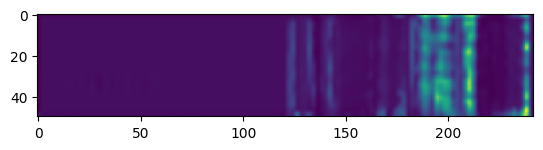

In [55]:
gradcam_tudo = np.zeros((50, 242))
for i in range(len(gradcam)):
    gradcam_tudo = (gradcam_tudo + gradcam[i])/2
plt.imshow(gradcam_tudo)